In [5]:
import pandas as pd


In [4]:
!pip install skforecast

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
datos_WATER=pd.read_csv('/content/drive/MyDrive/Modelar_UH2022.txt', header =0, na_values=['NaN'], sep='|', index_col=False)
print(datos_WATER)

            ID           SAMPLETIME  READINGINTEGER  READINGTHOUSANDTH  \
0            0  2019-06-13 08:34:09          369320                0.0   
1            0  2019-06-13 17:34:10          369403                0.0   
2            0  2019-06-13 18:34:10          369403                0.0   
3            0  2019-06-13 04:34:10          369284                0.0   
4            0  2019-06-13 14:34:10          369356                0.0   
...        ...                  ...             ...                ...   
21404823  2749  2019-10-11 06:27:14          164505                0.0   
21404824  2756  2019-04-06 05:50:17          349758                0.0   
21404825  2756  2019-04-06 07:50:17          349770                0.0   
21404826  2756  2019-04-06 04:50:17          349758                0.0   
21404827  2756  2019-04-06 06:50:17          349758                0.0   

          DELTAINTEGER  DELTATHOUSANDTH  
0                   17              0.0  
1                    2     

In [15]:
#Establecemos 'SAMPLETIME' como indice

datos_WATER['SAMPLETIME']=pd.to_datetime(datos_WATER['SAMPLETIME'], format='%Y-%m-%d %H:%M:%S')
datos_WATER=datos_WATER.set_index('SAMPLETIME')

In [7]:
def Convertir_Entero(serie):
    resultado = {}
    indices = []
    
    for indice, numero in serie.items():
        if numero < 10:
            resultado[indice] = numero/10
            indices.append(indice)
        elif numero < 100:
            resultado[indice] = numero/100
            indices.append(indice)
        elif numero >= 100:
            print('ERROR parte decimal mayor de 100')
    
    #print(resultado, indices)
    return pd.Series(data=resultado, index=indices)
            

datos_WATER['CONSUMO'] = datos_WATER['DELTAINTEGER'] + Convertir_Entero(datos_WATER['DELTATHOUSANDTH'])
#datos_WATER['LECTURA'] = datos_WATER['READINGINTEGER']+Convertir_Entero(datos_WATER['READINGTHOUSANDTH'])

In [9]:
datos_WATER['LECTURA'] = datos_WATER['READINGINTEGER']+Convertir_Entero(datos_WATER['READINGTHOUSANDTH'])

In [10]:
datos_WATER.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,CONSUMO,LECTURA
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0,17.0,369320.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0,2.0,369403.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0,0.0,369403.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0,1.0,369284.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0,28.0,369356.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0,0.0,369283.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0,42.0,369401.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0,0.0,369323.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0,15.0,369511.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0,41.0,369552.0


In [11]:
datos_WATER

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,CONSUMO,LECTURA
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0,17.0,369320.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0,2.0,369403.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0,0.0,369403.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0,1.0,369284.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0,28.0,369356.0
...,...,...,...,...,...,...,...,...
21404823,2749,2019-10-11 06:27:14,164505,0.0,0,0.0,0.0,164505.0
21404824,2756,2019-04-06 05:50:17,349758,0.0,0,0.0,0.0,349758.0
21404825,2756,2019-04-06 07:50:17,349770,0.0,12,0.0,12.0,349770.0
21404826,2756,2019-04-06 04:50:17,349758,0.0,0,0.0,0.0,349758.0


In [17]:
#1º SEPARAMOS DEPÓSITOS SEGÚN EL ID
a=datos_WATER.ID.unique()
print(len(a))



a=[]

for i in range(2757):
  a.append(datos_WATER[datos_WATER.ID==i])




2747


In [14]:
print(a[3].resample('d'))

DatetimeIndexResampler [freq=<Day>, axis=0, closed=left, label=left, convention=start, origin=start_day]


In [23]:
b=[]
delta=[]
read=[]
for i in range(2757):
  delta.append(a[i].resample('d').sum())
  read.append(a[i].resample('d').max())
  s=delta[i].shape[0]
  id=a[i].ID.unique()
  b.append((id,s))

In [20]:
delta[0]

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,CONSUMO,LECTURA
SAMPLETIME,,,,,,,
2019-02-01,0,7963359,0.0,243,0.0,243.0,7963359.0
2019-02-02,0,7969096,0.0,236,0.0,236.0,7969096.0
2019-02-03,0,7975263,0.0,335,0.0,335.0,7975263.0
2019-02-04,0,7982426,0.0,252,0.0,252.0,7982426.0
2019-02-05,0,7988972,0.0,220,0.0,220.0,7988972.0
...,...,...,...,...,...,...,...
2020-01-27,0,10404010,0.0,213,0.0,213.0,10404010.0
2020-01-28,0,10409421,0.0,232,0.0,232.0,10409421.0
2020-01-29,0,10416770,0.0,403,0.0,403.0,10416770.0


In [21]:
read[0]

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,CONSUMO,LECTURA
SAMPLETIME,,,,,,,
2019-02-01,0,331953,0.0,69,0.0,69.0,331953.0
2019-02-02,0,332189,0.0,61,0.0,61.0,332189.0
2019-02-03,0,332524,0.0,60,0.0,60.0,332524.0
2019-02-04,0,332776,0.0,97,0.0,97.0,332776.0
2019-02-05,0,332996,0.0,46,0.0,46.0,332996.0
...,...,...,...,...,...,...,...
2020-01-27,0,433651,0.0,55,0.0,55.0,433651.0
2020-01-28,0,433883,0.0,63,0.0,63.0,433883.0
2020-01-29,0,434286,0.0,85,0.0,85.0,434286.0


In [24]:
datos_WATER_final=[]

for i in range(2757):
  datos_WATER_final.append(pd.concat([read[i]['ID'], delta[i]['CONSUMO'], read[i]['LECTURA']], axis=1))




In [25]:
len(datos_WATER_final[0])

,ID,CONSUMO,LECTURA
SAMPLETIME,,,
2019-02-01,0,243.0,331953.0
2019-02-02,0,236.0,332189.0
2019-02-03,0,335.0,332524.0
2019-02-04,0,252.0,332776.0
2019-02-05,0,220.0,332996.0
...,...,...,...
2020-01-27,0,213.0,433651.0
2020-01-28,0,232.0,433883.0
2020-01-29,0,403.0,434286.0


In [26]:
len(datos_WATER_final[0])

365

In [ ]:
for i in range(2757):
  for j in range len(datos_WATER_final[i]):
    if j==0:
      datos_WATER_f
      datos_WATER_final[i]['COMPROBANTE_LECTURA'][j]=datos_WATER_final[i]['']

In [19]:
print(b[0])

(array([0]), 365)


In [20]:
print(b)
print(len(b))

[(array([0]), 365), (array([1]), 365), (array([2]), 365), (array([3]), 365), (array([4]), 365), (array([5]), 365), (array([6]), 365), (array([7]), 365), (array([8]), 365), (array([9]), 365), (array([10]), 365), (array([11]), 365), (array([12]), 365), (array([13]), 365), (array([14]), 365), (array([15]), 365), (array([16]), 365), (array([17]), 365), (array([18]), 365), (array([19]), 365), (array([20]), 365), (array([21]), 365), (array([22]), 365), (array([23]), 362), (array([24]), 365), (array([25]), 365), (array([26]), 269), (array([27]), 365), (array([28]), 365), (array([29]), 365), (array([30]), 365), (array([31]), 365), (array([32]), 301), (array([33]), 365), (array([34]), 269), (array([35]), 267), (array([36]), 365), (array([37]), 365), (array([38]), 365), (array([39]), 264), (array([40]), 365), (array([41]), 365), (array([42]), 365), (array([43]), 365), (array([44]), 365), (array([45]), 365), (array([46]), 365), (array([47]), 365), (array([48]), 365), (array([49]), 365), (array([5

In [22]:
#2º 
print(b[0][1])

365


In [23]:
df=pd.Series(['NUMREGISTROS'])

for i in range(2756):
  df[i]=b[i][1]


In [39]:
for i in range(4):
  print(i)

0
1
2
3


In [25]:
print(df)

0       365
1       365
2       365
3       365
4       365
       ... 
2751      0
2752      0
2753      0
2754      0
2755      0
Length: 2756, dtype: object


In [31]:
print(df.value_counts())

365    2203
271      37
267      36
264      19
25       18
       ... 
136       1
99        1
43        1
306       1
149       1
Length: 136, dtype: int64


In [37]:
data=pd.DataFrame(columns=['LONGITUD_TEMPORAL', 'NºDEPCONDICHALONGTEMP'])

data=df.value_counts()

In [38]:
print(data)

365    2203
271      37
267      36
264      19
25       18
       ... 
136       1
99        1
43        1
306       1
149       1
Length: 136, dtype: int64


In [26]:
df.unique()


array([365, 362, 269, 301, 267, 264, 270, 351, 271, 364, 312, 325, 356,
       257, 262, 221, 361, 338, 360, 354, 302, 347, 359, 363, 346, 260,
       293, 358, 339, 357, 247, 263, 243, 311, 295, 266, 322, 334, 291,
       239, 353, 237, 255, 234, 323, 309, 330, 348, 256, 289, 303, 313,
       254, 333, 349, 320, 355, 352, 340, 228, 196, 276, 213, 335, 345,
       233, 2, 88, 329, 286, 222, 298, 290, 108, 208, 205, 199, 225, 197,
       82, 110, 16, 87, 179, 176, 151, 106, 341, 75, 136, 122, 47, 307,
       99, 43, 25, 192, 306, 31, 169, 60, 67, 127, 109, 157, 101, 46, 171,
       64, 177, 142, 174, 116, 71, 126, 342, 331, 143, 129, 51, 103, 165,
       77, 90, 350, 11, 275, 184, 135, 5, 3, 0, 1, 4, 55, 149],
      dtype=object)

In [30]:
df.unique()

array([365, 362, 269, 301, 267, 264, 270, 351, 271, 364, 312, 325, 356,
       257, 262, 221, 361, 338, 360, 354, 302, 347, 359, 363, 346, 260,
       293, 358, 339, 357, 247, 263, 243, 311, 295, 266, 322, 334, 291,
       239, 353, 237, 255, 234, 323, 309, 330, 348, 256, 289, 303, 313,
       254, 333, 349, 320, 355, 352, 340, 228, 196, 276, 213, 335, 345,
       233, 2, 88, 329, 286, 222, 298, 290, 108, 208, 205, 199, 225, 197,
       82, 110, 16, 87, 179, 176, 151, 106, 341, 75, 136, 122, 47, 307,
       99, 43, 25, 192, 306, 31, 169, 60, 67, 127, 109, 157, 101, 46, 171,
       64, 177, 142, 174, 116, 71, 126, 342, 331, 143, 129, 51, 103, 165,
       77, 90, 350, 11, 275, 184, 135, 5, 3, 0, 1, 4, 55, 149],
      dtype=object)

In [ ]:
datos_WATER.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0


In [ ]:
datos_WATER['SAMPLETIME']=pd.to_datetime(datos_WATER['SAMPLETIME'], format='%Y-%m-%d %H:%M:%S')
datos_WATER=datos_WATER.set_index('SAMPLETIME')
#datos_WATER=datos_WATER.asfreq('MS')
datos_WATER=datos_WATER.sort_index()
datos_WATER.head(10)

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
SAMPLETIME,,,,,
2019-02-01,978,1022,0.0,0,0.0
2019-02-01,2144,87829,0.0,0,0.0
2019-02-01,1791,461138,4.0,0,2.0
2019-02-01,610,290969,67.0,5,33.0
2019-02-01,2263,319290,39.0,3,41.0
2019-02-01,264,185387,0.0,7,0.0
2019-02-01,2067,337183,56.0,11,56.0
2019-02-01,510,39767,35.0,4,35.0
2019-02-01,871,193678,33.0,3,44.0


In [ ]:
datos_ID0=datos_WATER[datos_WATER.ID==0]
datos_ID0.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.0,8759.000000,8759.000000,8759.000000,8759.000000
mean,0.0,383306.944857,0.029684,11.784564,0.039959
std,0.0,29487.925728,0.421001,20.465775,0.506412
min,0.0,331710.000000,0.000000,0.000000,0.000000
25%,0.0,357061.500000,0.000000,0.000000,0.000000
50%,0.0,384652.000000,0.000000,3.000000,0.000000
75%,0.0,408658.500000,0.000000,15.000000,0.000000
max,0.0,434966.000000,8.000000,264.000000,8.000000


In [ ]:
datos_ID0.head(100)

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
SAMPLETIME,,,,,
2019-02-01 00:39:36,0,331710,0.0,0,0.0
2019-02-01 01:39:36,0,331710,0.0,0,0.0
2019-02-01 02:39:35,0,331710,0.0,0,0.0
2019-02-01 03:39:35,0,331710,0.0,0,0.0
2019-02-01 04:39:35,0,331710,0.0,0,0.0
...,...,...,...,...,...
2019-02-04 23:39:27,0,332776,0.0,3,0.0
2019-02-05 00:39:27,0,332788,0.0,12,0.0
2019-02-05 01:39:27,0,332788,0.0,0,0.0


In [ ]:
datos_ID0READ=datos_ID0.resample('d').max()
print(datos_ID0READ)

            ID  READINGINTEGER  ...  DELTAINTEGER  DELTATHOUSANDTH
SAMPLETIME                      ...                               
2019-02-01   0          331953  ...            69              0.0
2019-02-02   0          332189  ...            61              0.0
2019-02-03   0          332524  ...            60              0.0
2019-02-04   0          332776  ...            97              0.0
2019-02-05   0          332996  ...            46              0.0
...         ..             ...  ...           ...              ...
2020-01-27   0          433651  ...            55              0.0
2020-01-28   0          433883  ...            63              0.0
2020-01-29   0          434286  ...            85              0.0
2020-01-30   0          434711  ...            96              0.0
2020-01-31   0          434966  ...            91              0.0

[365 rows x 5 columns]


In [ ]:
datos_ID0DELTA=datos_ID0.resample('d').sum()
print(datos_ID0DELTA)

            ID  READINGINTEGER  ...  DELTAINTEGER  DELTATHOUSANDTH
SAMPLETIME                      ...                               
2019-02-01   0         7963359  ...           243              0.0
2019-02-02   0         7969096  ...           236              0.0
2019-02-03   0         7975263  ...           335              0.0
2019-02-04   0         7982426  ...           252              0.0
2019-02-05   0         7988972  ...           220              0.0
...         ..             ...  ...           ...              ...
2020-01-27   0        10404010  ...           213              0.0
2020-01-28   0        10409421  ...           232              0.0
2020-01-29   0        10416770  ...           403              0.0
2020-01-30   0        10427437  ...           425              0.0
2020-01-31   0        10435512  ...           255              0.0

[365 rows x 5 columns]


In [ ]:
datos_ID0READDELTA=pd.concat([datos_ID0READ.READINGINTEGER, datos_ID0DELTA.DELTAINTEGER], axis=1)
print(datos_ID0READDELTA)

            READINGINTEGER  DELTAINTEGER
SAMPLETIME                              
2019-02-01          331953           243
2019-02-02          332189           236
2019-02-03          332524           335
2019-02-04          332776           252
2019-02-05          332996           220
...                    ...           ...
2020-01-27          433651           213
2020-01-28          433883           232
2020-01-29          434286           403
2020-01-30          434711           425
2020-01-31          434966           255

[365 rows x 2 columns]


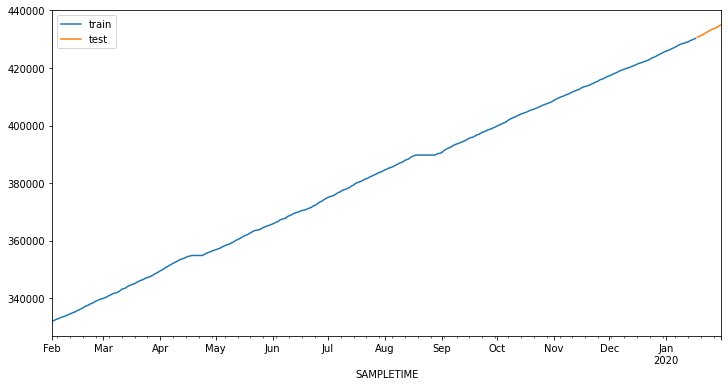

In [ ]:
import matplotlib.pyplot as plt

steps=14
datos_train=datos_ID0READDELTA[:-steps]
datos_test=datos_ID0READDELTA[-steps:]

fig, ax=plt.subplots(figsize=(12,6))
datos_train['READINGINTEGER'].plot(ax=ax, label='train')
datos_test['READINGINTEGER'].plot(ax=ax, label='test')
ax.legend();



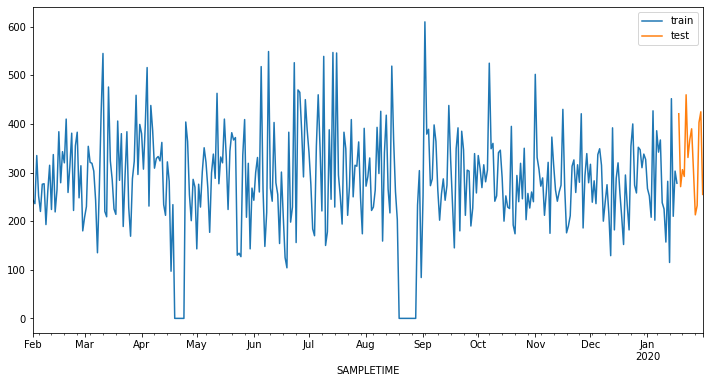

In [ ]:
steps=14
datos_train=datos_ID0READDELTA[:-steps]
datos_test=datos_ID0READDELTA[-steps:]

fig, ax=plt.subplots(figsize=(12,6))
datos_train['DELTAINTEGER'].plot(ax=ax, label='train')
datos_test['DELTAINTEGER'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
forecaster= ForecasterAutoreg(
      regressor=RandomForestRegressor(random_state=123), lags=14
)

forecaster.fit(y=datos_train['DELTAINTEGER'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-02-01 00:00:00'), Timestamp('2020-01-17 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-01 09:19:50 
Last fit date: 2022-03-01 09:19:50 
Skforecast version: 0.4.2 

In [ ]:
steps=14
predicciones=forecaster.predict(steps=steps)
predicciones.head(5)

2020-01-18    293.94
2020-01-19    281.43
2020-01-20    265.75
2020-01-21    291.10
2020-01-22    324.71
Freq: D, Name: pred, dtype: float64

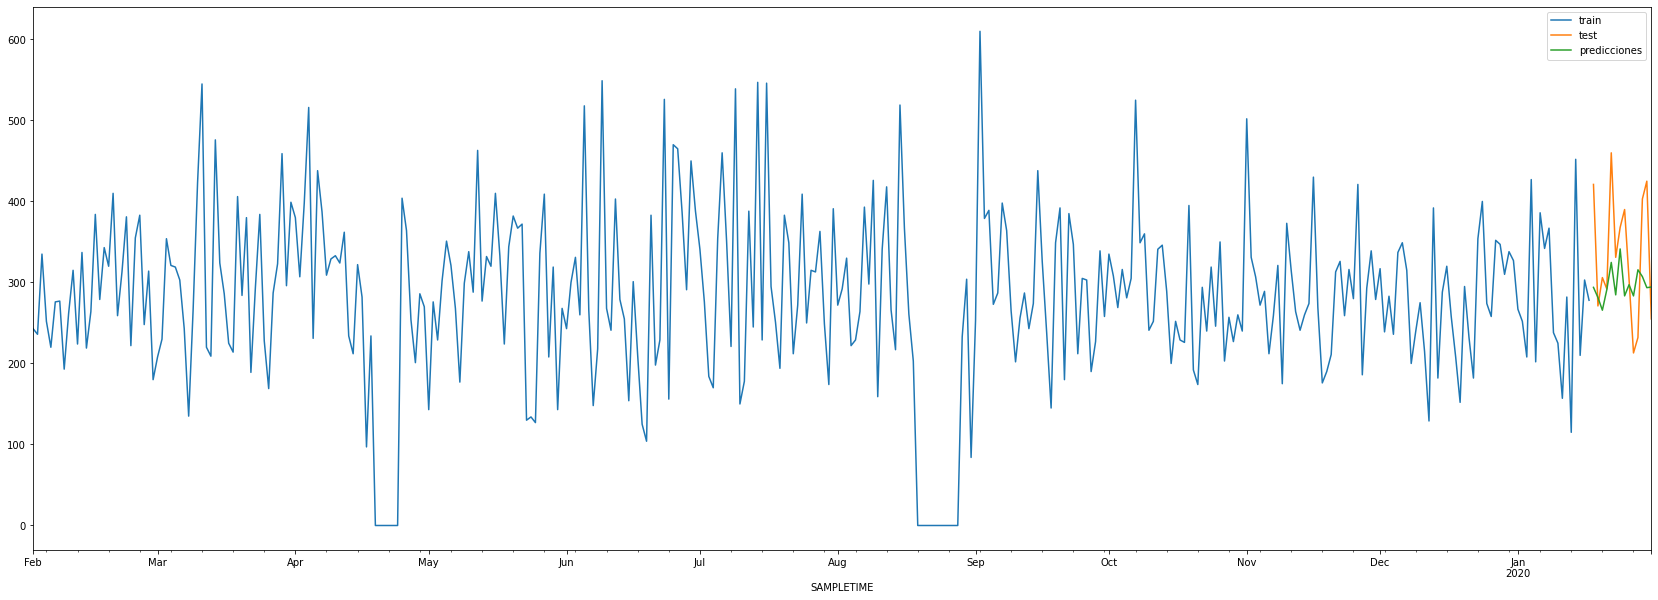

In [ ]:
fig, ax = plt.subplots(figsize=(29, 10))
datos_train['DELTAINTEGER'].plot(ax=ax, label='train')
datos_test['DELTAINTEGER'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
error_mse = mean_squared_error(
                y_true = datos_test['DELTAINTEGER'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 6455.476307142858


In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags utilizados como predictores
lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['DELTAINTEGER'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 14,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.8),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:18<00:00, 39.23s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 5410.465557809729



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,metric,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",5410.465558,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",5484.282927,5,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",5568.130319,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",5570.888225,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",5580.013797,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",5625.163775,3,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",5748.968360,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",5756.510596,3,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",5826.975205,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",5877.498564,5,100


In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['DELTAINTEGER'])

In [ ]:
predicciones=forecaster.predict(steps=14)

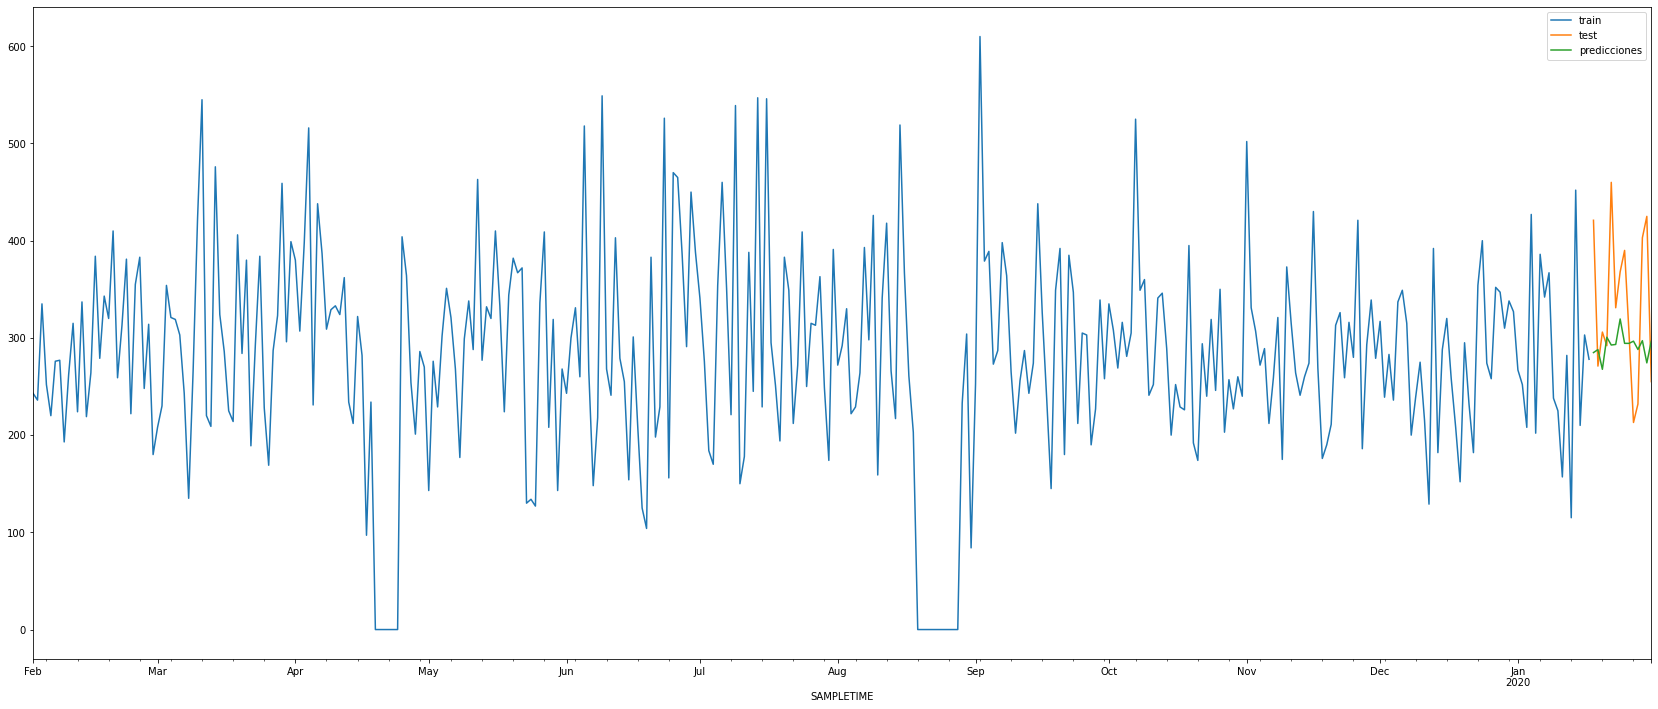

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(29, 12))
datos_train['DELTAINTEGER'].plot(ax=ax, label='train')
datos_test['DELTAINTEGER'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['DELTAINTEGER'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 7652.993582082704


In [ ]:
importancia=forecaster.get_feature_importance()
importancia

,feature,importance
0,lag_1,0.417403
1,lag_2,0.074279
2,lag_3,0.028827
3,lag_4,0.020902
4,lag_5,0.024855
5,lag_6,0.018975
6,lag_7,0.018980
7,lag_8,0.019256
8,lag_9,0.020497
9,lag_10,0.026945


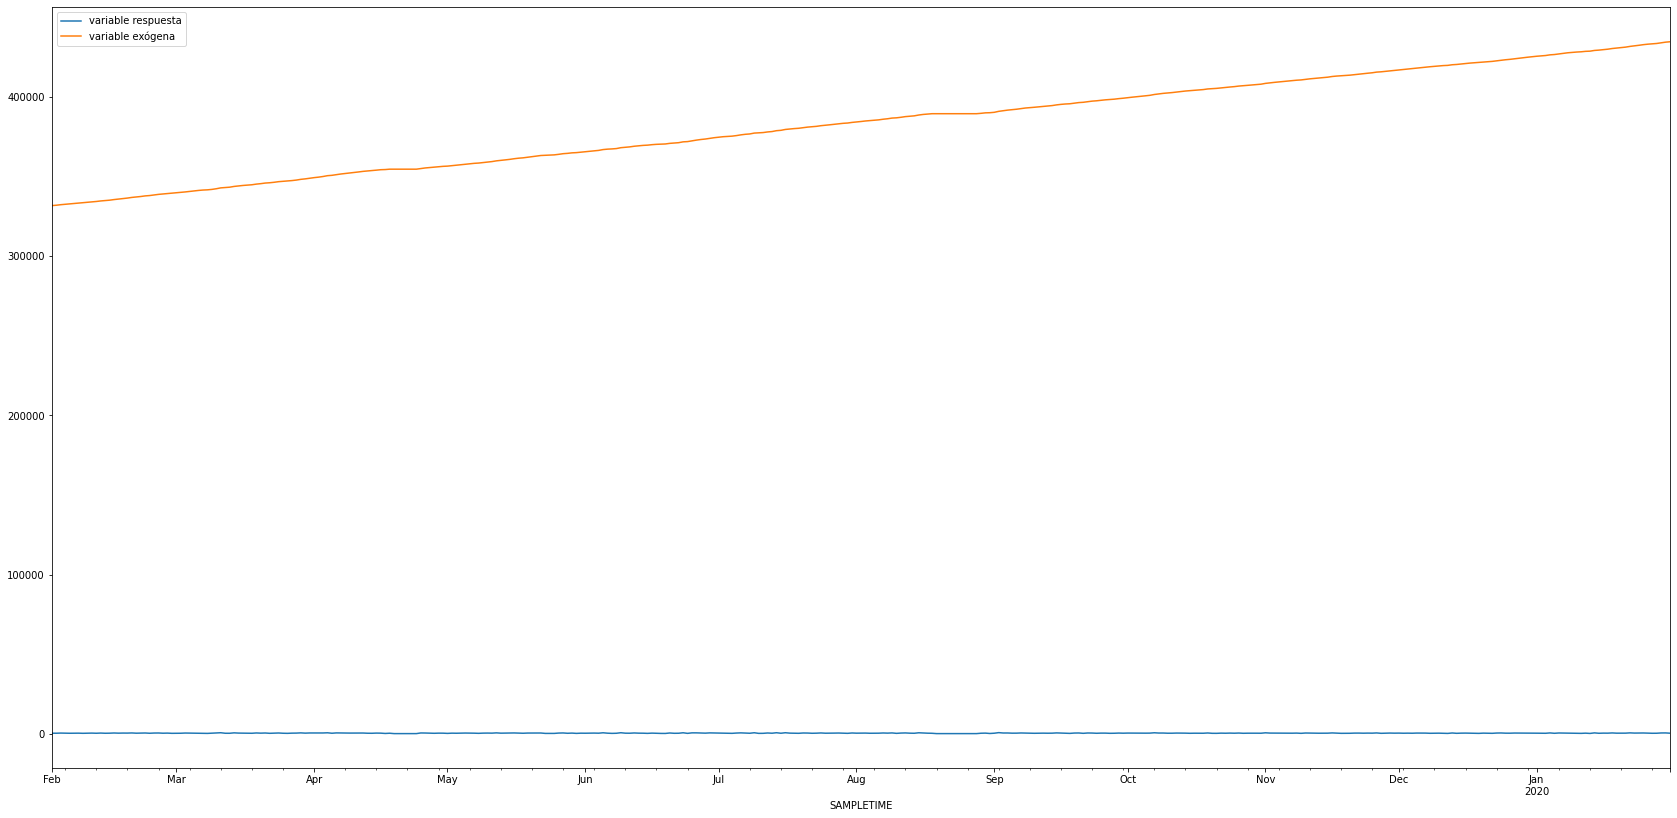

In [ ]:
fig, ax = plt.subplots(figsize=(29, 14))
datos_ID0READDELTA['DELTAINTEGER'].plot(ax=ax, label='variable respuesta')
datos_ID0READDELTA['READINGINTEGER'].plot(ax=ax, label='variable exógena')
ax.legend();



In [ ]:
steps=14
datos_train=datos_ID0READDELTA[:-steps]
datos_test=datos_ID0READDELTA[-steps:]


In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 20
             )
forecaster.fit(y=datos_train['DELTAINTEGER'], exog=datos_train['READINGINTEGER'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Window size: 20 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: READINGINTEGER 
Training range: [Timestamp('2019-02-01 00:00:00'), Timestamp('2020-01-17 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-01 09:58:06 
Last fit date: 2022-03-01 09:58:07 
Skforecast version: 0.4.2 

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['READINGINTEGER'])

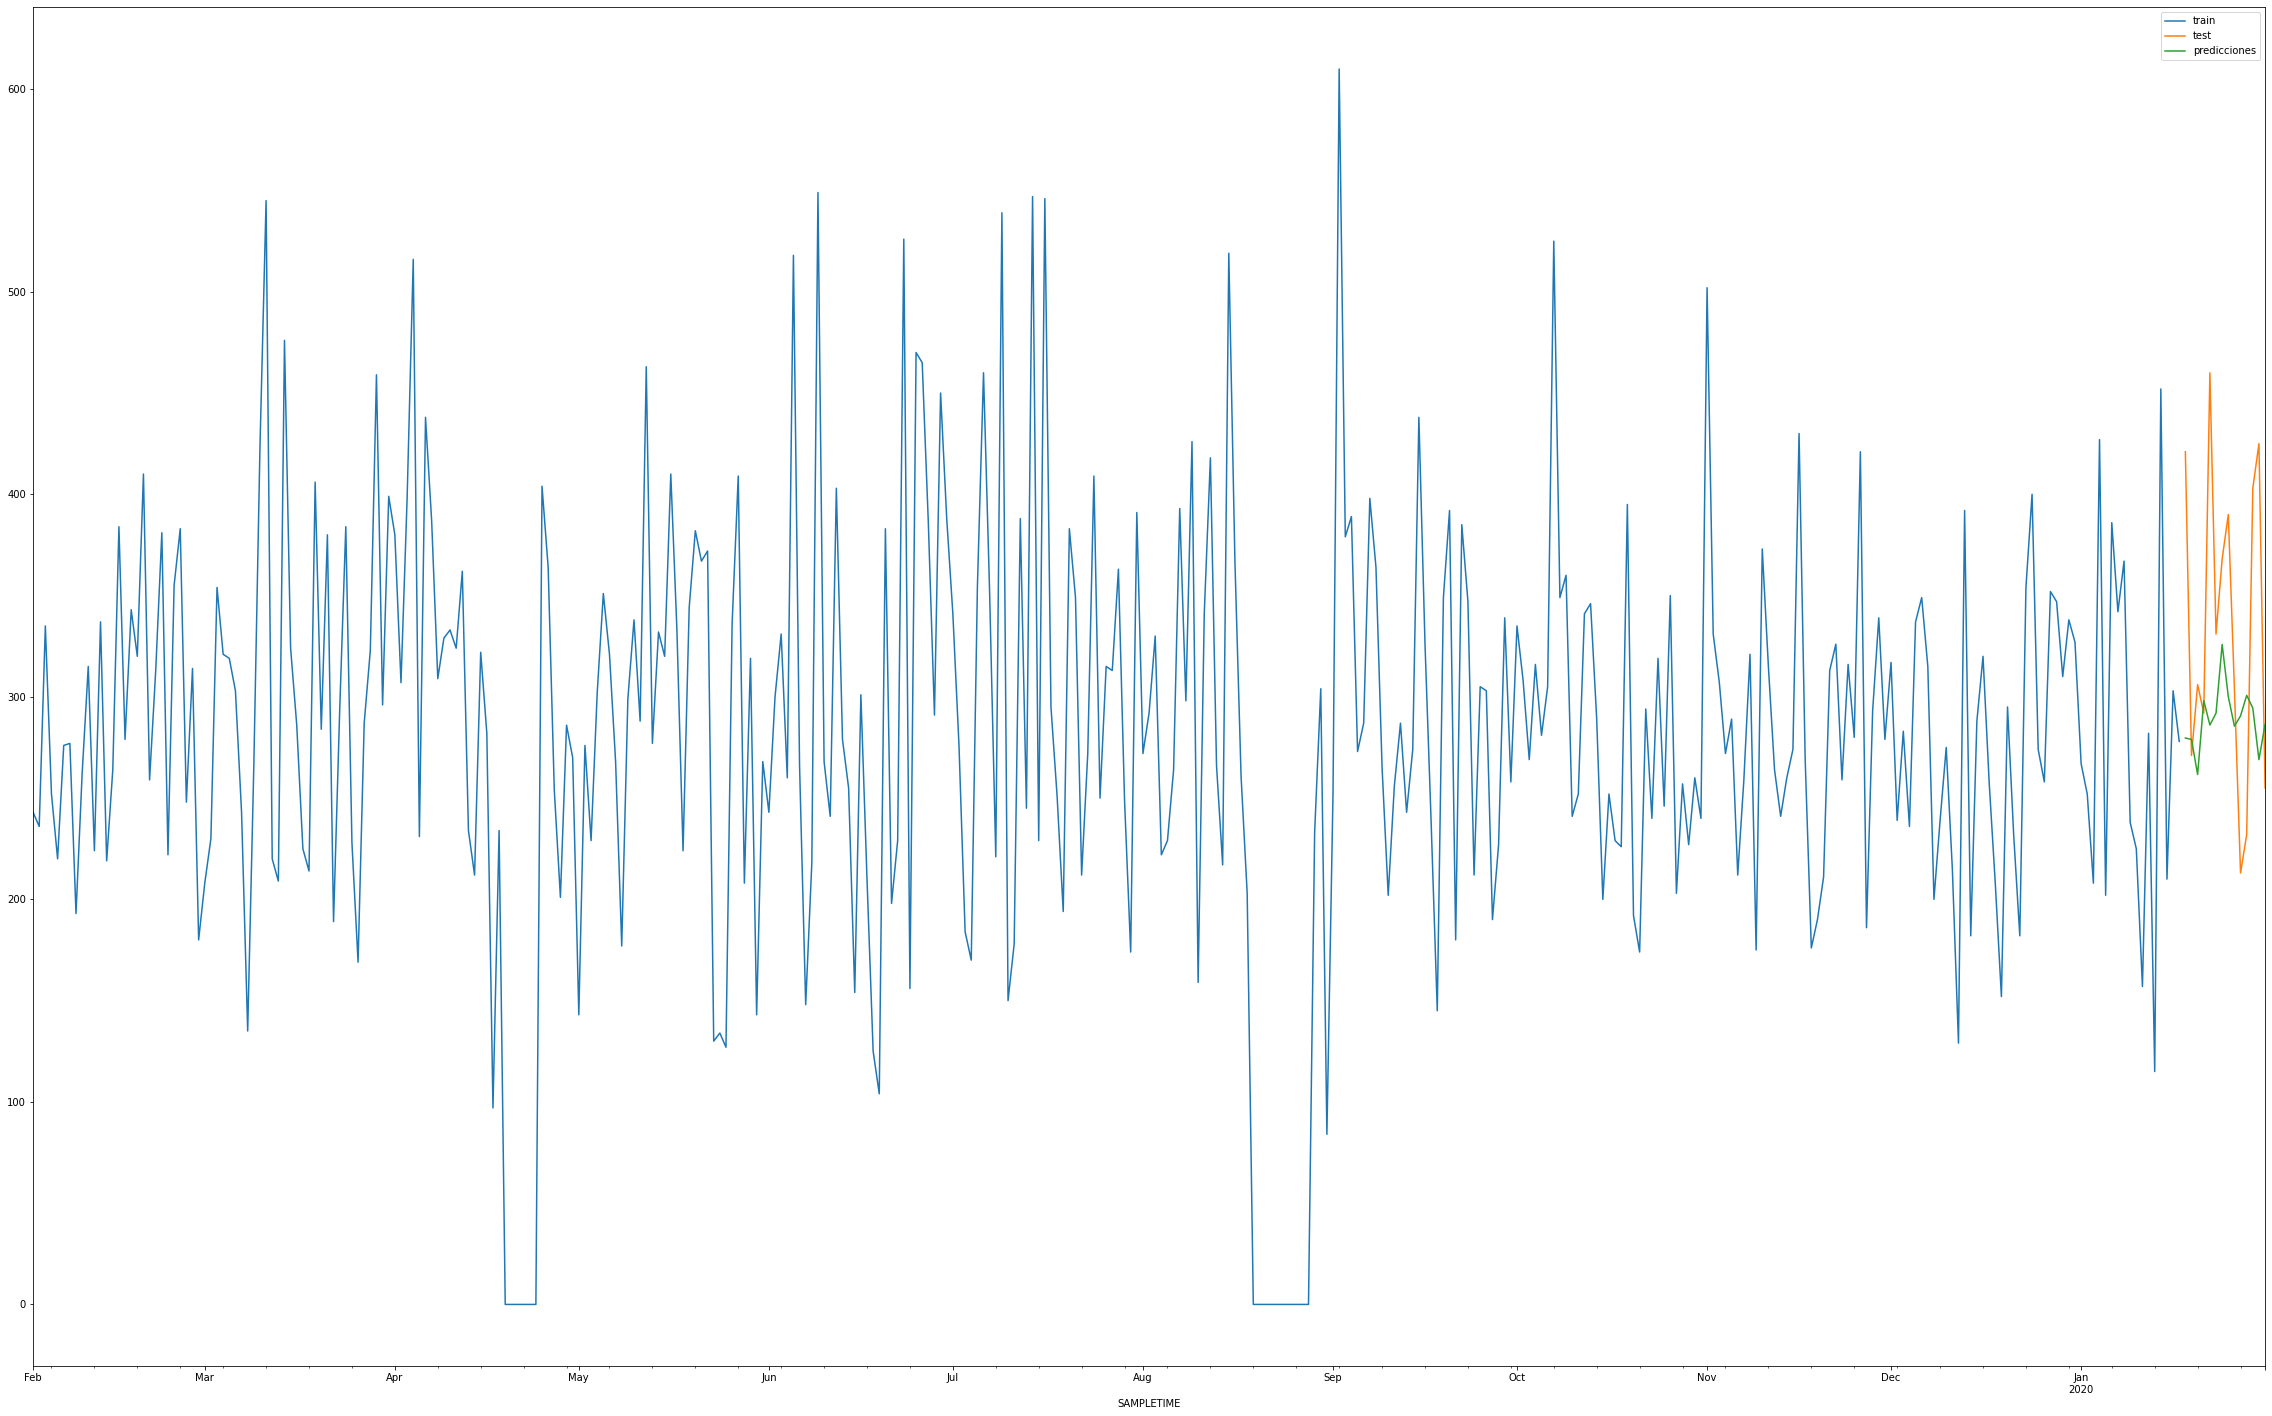

In [ ]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(40, 25))
datos_train['DELTAINTEGER'].plot(ax=ax, label='train')
datos_test['DELTAINTEGER'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['DELTAINTEGER'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 7991.3704


In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['DELTAINTEGER'],
                        exog        = datos_train['READINGINTEGER'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.8),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 27


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:36<00:00, 52.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 50}
  Backtesting metric: 5185.809834113122



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

,lags,params,metric,max_depth,n_estimators
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",5185.809834,10,50
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",5407.788252,10,500
21,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",5443.158960,5,50
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",5477.318155,3,50
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",5483.881506,5,500


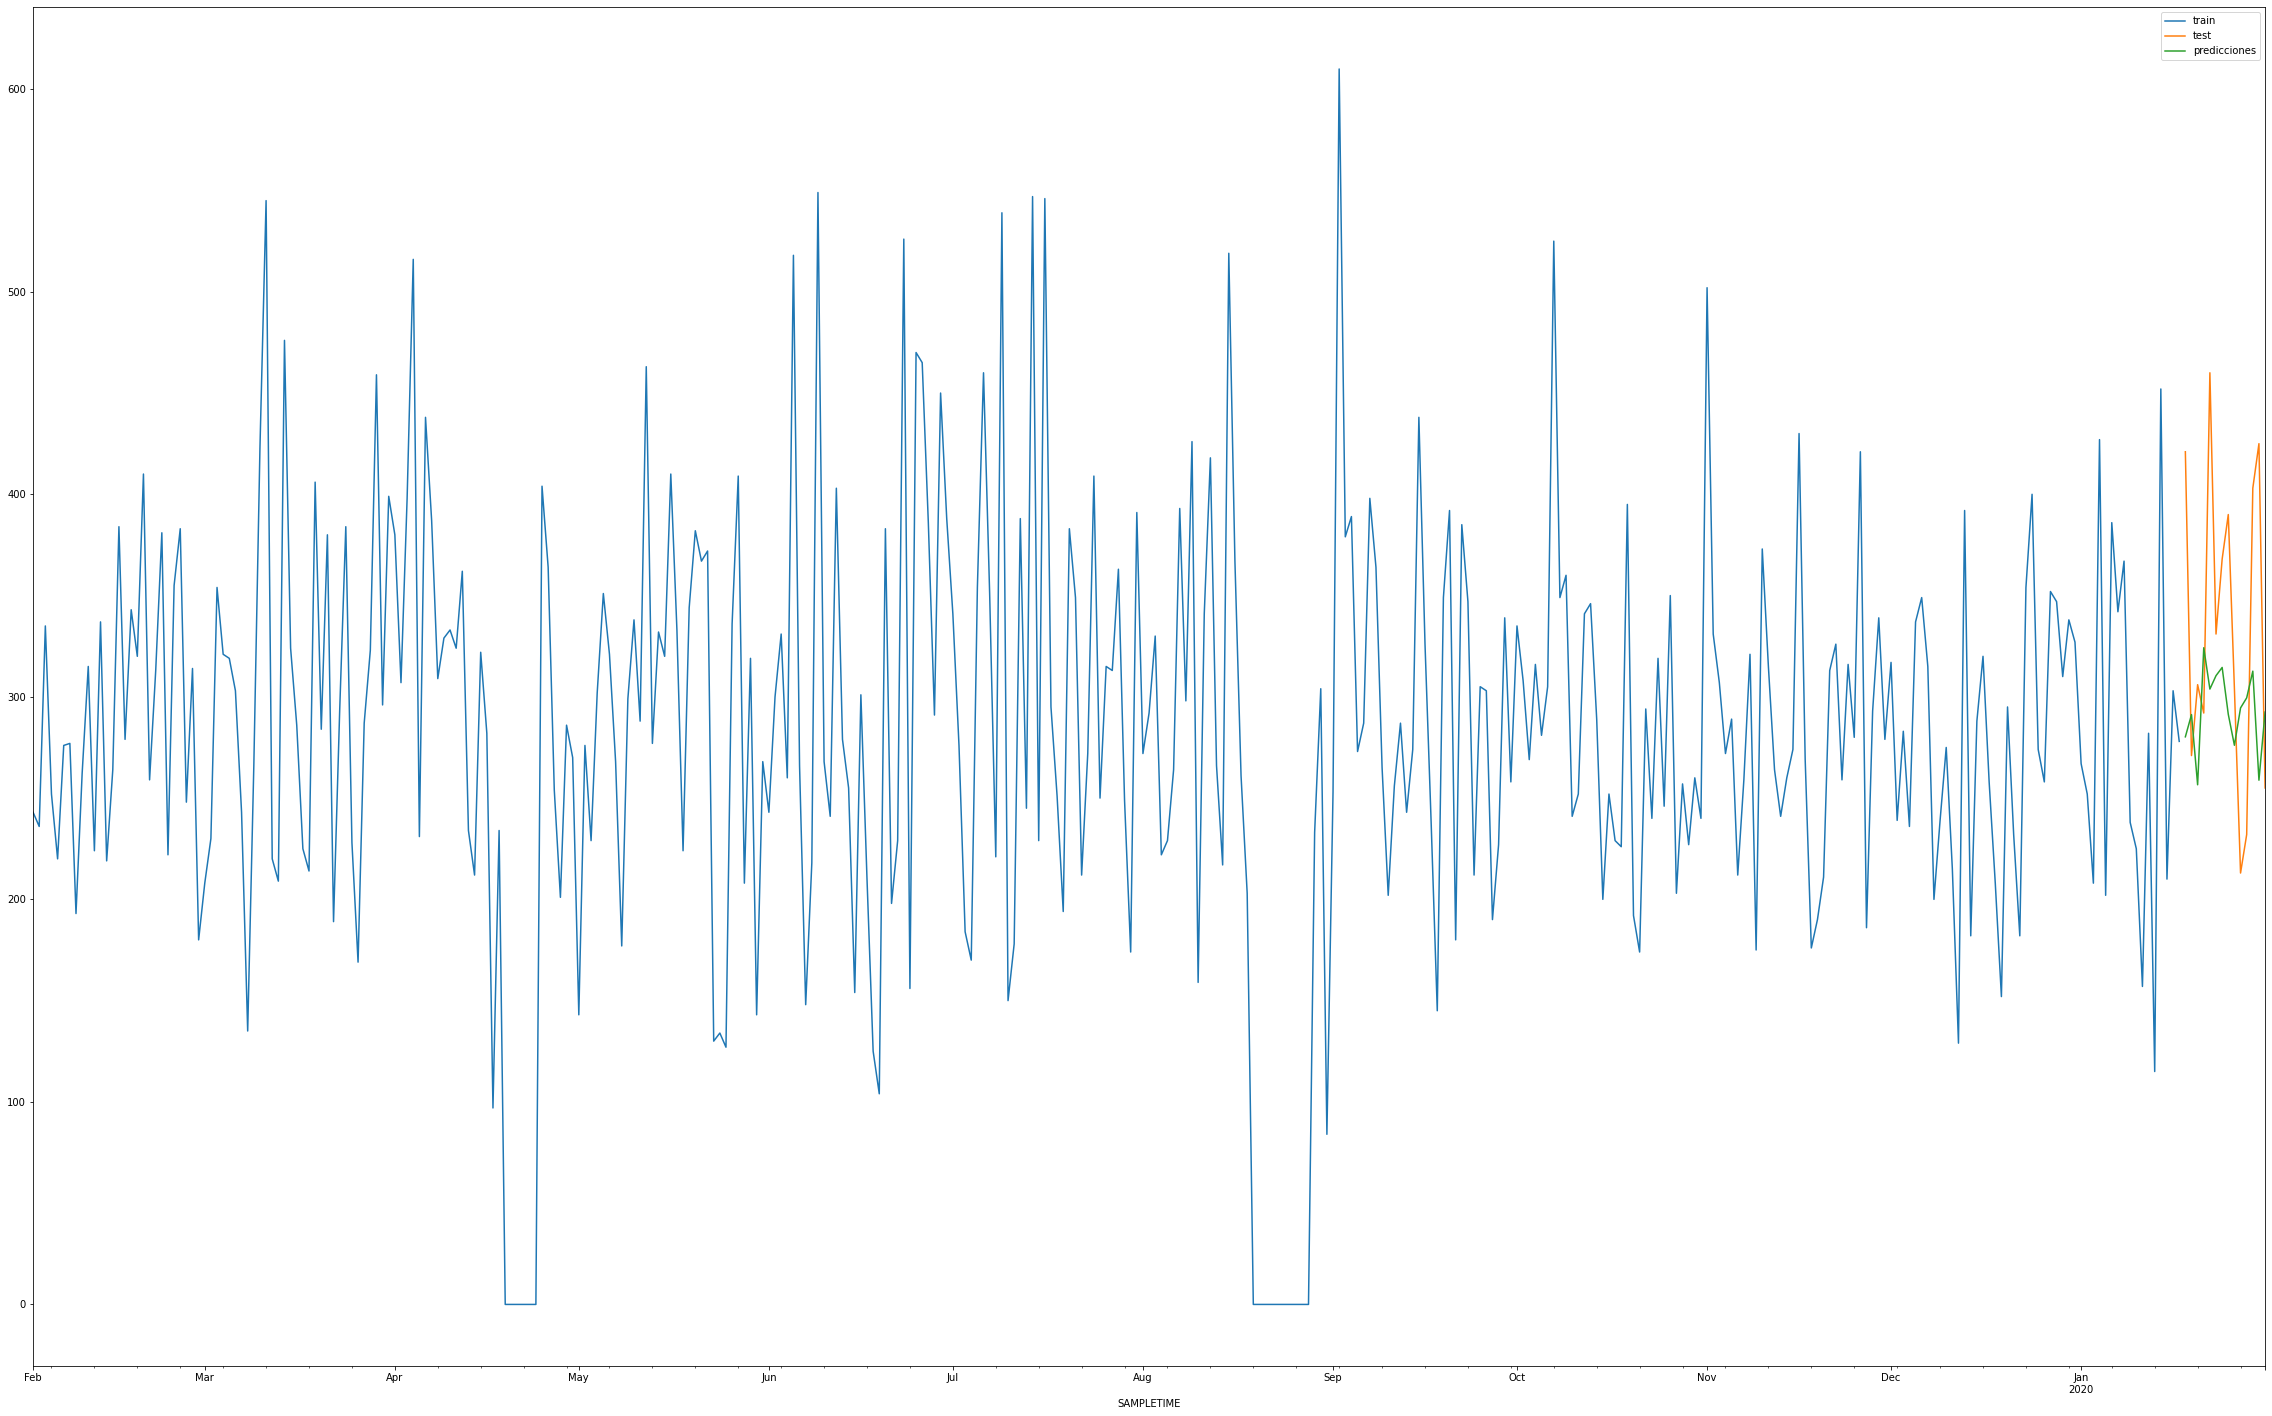

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['READINGINTEGER'])

# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(40, 25))
datos_train['DELTAINTEGER'].plot(ax=ax, label='train')
datos_test['DELTAINTEGER'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['DELTAINTEGER'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 7875.568814064373


In [ ]:
print(datos_WATER)

                       ID  READINGINTEGER  ...  DELTAINTEGER  DELTATHOUSANDTH
SAMPLETIME                                 ...                               
2019-06-13 08:34:09     0          369320  ...            17              0.0
2019-06-13 17:34:10     0          369403  ...             2              0.0
2019-06-13 18:34:10     0          369403  ...             0              0.0
2019-06-13 04:34:10     0          369284  ...             1              0.0
2019-06-13 14:34:10     0          369356  ...            28              0.0
...                   ...             ...  ...           ...              ...
2019-10-11 06:27:14  2749          164505  ...             0              0.0
2019-04-06 05:50:17  2756          349758  ...             0              0.0
2019-04-06 07:50:17  2756          349770  ...            12              0.0
2019-04-06 04:50:17  2756          349758  ...             0              0.0
2019-04-06 06:50:17  2756          349758  ...             0    

In [ ]:
datos_WATER.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,2.140483e+07,2.140483e+07,2.126477e+07,2.140483e+07,2.126477e+07
mean,1.259029e+03,6.052178e+05,3.930737e+00,2.277017e+01,4.228367e+00
std,7.334956e+02,2.857464e+06,1.496893e+01,1.516794e+03,1.541059e+01
min,0.000000e+00,-6.407800e+04,0.000000e+00,-5.307340e+05,0.000000e+00
25%,6.230000e+02,6.368800e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.255000e+03,1.831570e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.887000e+03,3.520500e+05,0.000000e+00,9.000000e+00,0.000000e+00
max,2.756000e+03,5.108976e+07,9.900000e+01,9.499810e+05,9.900000e+01


In [ ]:
cont_negativos=datos_WATER[datos_WATER['READINGINTEGER']<=0]

In [ ]:
print(cont_negativos)

            ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
2318855    272 2019-06-13 04:27:57  ...             0              0.0
2318856    272 2019-06-13 20:27:57  ...             0              0.0
2318857    272 2019-06-13 12:27:56  ...             0              0.0
2318858    272 2019-06-13 15:27:57  ...             0              0.0
2318859    272 2019-06-13 23:27:57  ...             0              0.0
...        ...                 ...  ...           ...              ...
21396595  2711 2019-12-18 22:22:24  ...             0              0.0
21396596  2711 2019-12-19 18:22:22  ...           139              0.0
21396597  2711 2019-12-19 20:22:22  ...             0              0.0
21396598  2711 2020-01-11 04:21:35  ...             1              0.0
21396599  2711 2020-01-12 00:21:32  ...             0              0.0

[58924 rows x 6 columns]


In [ ]:
cont_negativos.head(100)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
2318855,272,2019-06-13 04:27:57,0,0.0,0,0.0
2318856,272,2019-06-13 20:27:57,0,0.0,0,0.0
2318857,272,2019-06-13 12:27:56,0,0.0,0,0.0
2318858,272,2019-06-13 15:27:57,0,0.0,0,0.0
2318859,272,2019-06-13 23:27:57,0,0.0,0,0.0
...,...,...,...,...,...,...
2318950,272,2019-06-17 08:27:51,0,0.0,0,0.0
2318951,272,2019-06-17 04:27:52,0,0.0,0,0.0
2318952,272,2019-06-17 21:27:52,0,0.0,0,0.0
2318953,272,2019-06-17 22:27:52,0,0.0,0,0.0


In [ ]:
print(datos_ID323)

          ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
2774271  323 2019-06-13 05:35:08  ...             0              0.0
2774272  323 2019-06-13 04:35:08  ...             0              0.0
2774273  323 2019-06-13 17:35:08  ...             0              0.0
2774274  323 2019-06-13 18:35:08  ...             0              0.0
2774275  323 2019-06-13 10:35:08  ...             0              0.0
...      ...                 ...  ...           ...              ...
2780659  323 2019-09-19 08:31:14  ...             0              0.0
2780660  323 2020-01-11 04:26:38  ...             0              0.0
2780661  323 2020-01-12 00:26:37  ...             0              0.0
2780662  323 2020-01-14 04:26:31  ...             0              0.0
2780663  323 2020-01-25 09:26:05  ...             0              0.0

[6393 rows x 6 columns]


In [ ]:
print(datos_ID461)

          ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
3940104  461 2019-06-13 05:34:46  ...             0              0.0
3940105  461 2019-06-13 11:34:47  ...             0              0.0
3940106  461 2019-06-13 16:34:47  ...             0              0.0
3940107  461 2019-06-13 10:34:47  ...             1              0.0
3940108  461 2019-06-13 12:34:47  ...             0              0.0
...      ...                 ...  ...           ...              ...
3946537  461 2019-09-19 20:31:51  ...             0              0.0
3946538  461 2020-01-11 04:28:17  ...             0              0.0
3946539  461 2020-01-12 00:28:14  ...             0              0.0
3946540  461 2020-01-14 04:28:12  ...             0              0.0
3946541  461 2020-01-25 09:27:52  ...             0              0.0

[6438 rows x 6 columns]


In [ ]:
cont_negativos.ID.unique()

array([ 272,  323,  461,  549, 1041, 1225, 1261, 1506, 1837, 1896, 2001,
       2089, 2135, 2231, 2369, 2542, 2544, 2545, 2547, 2690, 2711])

In [ ]:
datos_ID461=datos_WATER[datos_WATER.ID==461]
datos_ID461.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,6438.0,6438.000000,6438.0,6438.000000,6438.0
mean,461.0,135.624262,0.0,0.078441,0.0
std,0.0,167.634103,0.0,1.241118,0.0
min,461.0,0.000000,0.0,0.000000,0.0
25%,461.0,19.000000,0.0,0.000000,0.0
50%,461.0,41.000000,0.0,0.000000,0.0
75%,461.0,324.000000,0.0,0.000000,0.0
max,461.0,505.000000,0.0,44.000000,0.0


In [ ]:
datos_ID549=datos_WATER[datos_WATER.ID==549]
datos_ID549.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,6444.0,6444.000000,6444.000000,6444.000000,6444.000000
mean,549.0,68229.081006,0.121819,21.795313,0.144320
std,0.0,42077.852893,0.845818,45.279491,0.911732
min,549.0,0.000000,0.000000,0.000000,0.000000
25%,549.0,37262.750000,0.000000,0.000000,0.000000
50%,549.0,66409.500000,0.000000,8.000000,0.000000
75%,549.0,105301.000000,0.000000,30.000000,0.000000
max,549.0,140706.000000,8.000000,908.000000,8.000000


In [ ]:
print(datos_ID549)

          ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
4718674  549 2019-06-13 12:05:38  ...            18              0.0
4718675  549 2019-06-13 19:05:38  ...             3              0.0
4718676  549 2019-06-13 02:05:37  ...            50              0.0
4718677  549 2019-06-13 00:05:37  ...             4              0.0
4718678  549 2019-06-13 17:05:38  ...            13              0.0
...      ...                 ...  ...           ...              ...
4725113  549 2020-01-14 00:59:12  ...             0              0.0
4725114  549 2020-01-20 00:59:03  ...            52              0.0
4725115  549 2020-01-24 06:00:00  ...            23              8.0
4725116  549 2020-01-24 05:58:58  ...             2              0.0
4725117  549 2020-01-25 15:58:55  ...            34              0.0

[6444 rows x 6 columns]


In [ ]:
def descriptor(datos, num_ID):
  datos_W=datos[datos.ID==num_ID]
  return datos_W.describe(), datos_W.shape

In [ ]:
descriptor(datos_WATER,1041)

(           ID  READINGINTEGER  READINGTHOUSANDTH  DELTAINTEGER  DELTATHOUSANDTH
 count  8759.0     8759.000000        8759.000000   8759.000000      8759.000000
 mean   1041.0   -26228.186323           0.445256      0.761046         0.431899
 std       0.0     2167.364483           4.986136      7.039808         4.830244
 min    1041.0   -29505.000000           0.000000    -10.000000         0.000000
 25%    1041.0   -28241.000000           0.000000      0.000000         0.000000
 50%    1041.0   -26286.000000           0.000000      0.000000         0.000000
 75%    1041.0   -23892.000000           0.000000      0.000000         0.000000
 max    1041.0   -22759.000000          92.000000    327.000000        78.000000,
 (8759, 6),
            ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
 8892823  1041 2019-06-13 05:00:00  ...             0              0.0
 8892824  1041 2019-06-13 20:38:40  ...             5              0.0
 8892825  1041 2019-06-13 02:38:44  ...      

In [ ]:
array([ 272,  323,  461,  549, 1041, 1225, 1261, 1506, 1837, 1896, 2001,
       2089, 2135, 2231, 2369, 2542, 2544, 2545, 2547, 2690, 2711])

In [ ]:
descriptor(datos_WATER,1225)

(           ID  READINGINTEGER  READINGTHOUSANDTH  DELTAINTEGER  DELTATHOUSANDTH
 count  6490.0     6490.000000             6490.0   6490.000000           6490.0
 mean   1225.0       10.944530                0.0      0.004931              0.0
 std       0.0        8.643199                0.0      0.168319              0.0
 min    1225.0        0.000000                0.0      0.000000              0.0
 25%    1225.0        7.000000                0.0      0.000000              0.0
 50%    1225.0        8.000000                0.0      0.000000              0.0
 75%    1225.0       12.000000                0.0      0.000000              0.0
 max    1225.0       32.000000                0.0     10.000000              0.0,
 (6490, 6),
             ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
 10453300  1225 2019-06-13 05:29:04  ...             0              0.0
 10453301  1225 2019-06-13 14:29:06  ...             0              0.0
 10453302  1225 2019-06-13 15:29:06  ...  

In [ ]:
lista=[1261, 1506, 1837, 1896, 2001,
       2089, 2135, 2231, 2369, 2542, 2544, 2545, 2547, 2690, 2711]

In [ ]:
for i in lista:
  print(descriptor(datos_WATER, i))

(           ID  READINGINTEGER  READINGTHOUSANDTH  DELTAINTEGER  DELTATHOUSANDTH
count  6392.0     6392.000000        6392.000000   6392.000000      6392.000000
mean   1261.0     1456.762829           0.003129      1.290050         0.001564
std       0.0     2033.862771           0.136991      8.646414         0.055919
min    1261.0        0.000000           0.000000     -2.000000         0.000000
25%    1261.0      133.000000           0.000000      0.000000         0.000000
50%    1261.0      869.000000           0.000000      0.000000         0.000000
75%    1261.0      932.000000           0.000000      0.000000         0.000000
max    1261.0     8247.000000           8.000000    255.000000         2.000000, (6392, 6),             ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
10749742  1261 2019-06-13 15:10:55  ...             0              0.0
10749743  1261 2019-06-13 20:10:53  ...             0              0.0
10749744  1261 2019-06-13 11:10:54  ...            -1 

In [ ]:
datos_ID272=datos_WATER[datos_WATER.ID==272]
datos_ID272.head(30)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
2318855,272,2019-06-13 04:27:57,0,0.0,0,0.0
2318856,272,2019-06-13 20:27:57,0,0.0,0,0.0
2318857,272,2019-06-13 12:27:56,0,0.0,0,0.0
2318858,272,2019-06-13 15:27:57,0,0.0,0,0.0
2318859,272,2019-06-13 23:27:57,0,0.0,0,0.0
2318860,272,2019-06-13 17:27:57,0,0.0,0,0.0
2318861,272,2019-06-13 16:27:57,0,0.0,0,0.0
2318862,272,2019-06-13 08:27:57,0,0.0,0,0.0
2318863,272,2019-06-13 00:27:59,0,0.0,0,0.0
2318864,272,2019-06-13 10:27:56,0,0.0,0,0.0


In [ ]:
datos_ID272.describe()

,ID,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.0,8759.0,8759.0,8759.0,8759.0
mean,272.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,272.0,0.0,0.0,0.0,0.0
25%,272.0,0.0,0.0,0.0,0.0
50%,272.0,0.0,0.0,0.0,0.0
75%,272.0,0.0,0.0,0.0,0.0
max,272.0,0.0,0.0,0.0,0.0


In [ ]:
print(datos_ID272)

          ID          SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
2318855  272 2019-06-13 04:27:57  ...             0              0.0
2318856  272 2019-06-13 20:27:57  ...             0              0.0
2318857  272 2019-06-13 12:27:56  ...             0              0.0
2318858  272 2019-06-13 15:27:57  ...             0              0.0
2318859  272 2019-06-13 23:27:57  ...             0              0.0
...      ...                 ...  ...           ...              ...
2327609  272 2019-04-23 04:29:21  ...             0              0.0
2327610  272 2019-04-23 00:29:24  ...             0              0.0
2327611  272 2019-04-23 05:29:23  ...             0              0.0
2327612  272 2020-01-11 04:22:26  ...             0              0.0
2327613  272 2020-01-12 00:22:24  ...             0              0.0

[8759 rows x 6 columns]


In [ ]:
datos_WATER.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0


In [ ]:
a=str(datos_WATER.READINGINTEGER[1])
print(a)

369403


In [ ]:
steps=14
datos_train=datos_WATER[:-steps]
datos_test=datos[-steps:]

fig, ax = plt.subplots(figsize=(9,4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')

In [ ]:
a=[]
for i in range(len(datos_WATER)):
  a.append(str(datos_WATER.READINGINTEGER[i]))



In [ ]:
b=[]
for i in range(len(datos_WATER)):
  b.append(str(datos_WATER.READINGTHOUSANDTH[i]))

In [ ]:
datos_WATER['STRREADINT']=a

In [ ]:
datos_WATER['STRREADDEC']=b

In [ ]:
e, d = math.modf(datos_WATER.READINGTHOUSANDTH[0])


In [ ]:
print(e)
print(d)

0.0
0.0


In [ ]:
import math
e_r=[]
d_r=[]
e_d=[]
d_d=[]

e_r, d_r=math.modf(datos_WATER.READINGTHOUSANDTH)
e_d, d_d=math.modf(datos_WATER.DELTATHOUSANDTH)

TypeError: ignored

In [ ]:
for i in range(len(datos_WATER)):
  a[i]=len()

In [ ]:
len(datos_WATER)

21404828

In [ ]:
for i in range(3):
  print(i)

0
1
2


In [ ]:
for i in range(len(datos_WATER)):
  datos_WATER['LENREADTHOUSANDTH'][i]=len(datos_WATER.READINGTHOUSANDTH[i])

TypeError: ignored

In [ ]:
datos_WATER['READINGINTSTRBUENO']=len(str(datos_WATER['READINGINTEGER']))

In [ ]:
datos_WATER['READINGINTSTR']=str(datos_WATER.READINGINTEGER)

In [ ]:
datos_WATER['READINGDECSTR']=str(datos_WATER.READINGTHOUSANDTH)

In [ ]:
a=str(2022)
print(a)

2022


In [ ]:
datos_WATER.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,READINGINTSTR,READINGDECSTR,READINGINTSTRBUENO
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0,0 369320\n1 369403\n2 ...,0 0.0\n1 0.0\n2 ...,261


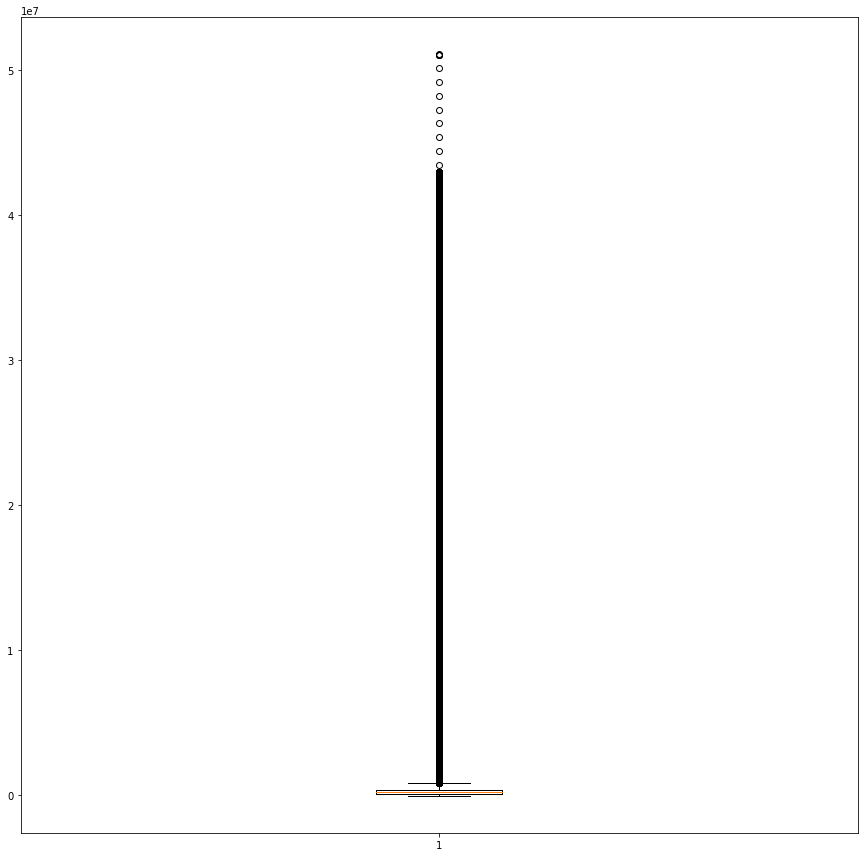

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,15))

plt.boxplot(datos_WATER.READINGINTEGER)
plt.show()

In [ ]:
print(datos_WATER.READINGTHOUSANDTH.mean())
print(datos_WATER.READINGTHOUSANDTH.std())

3.9307367603094923
14.968931952774467


numpy.float64

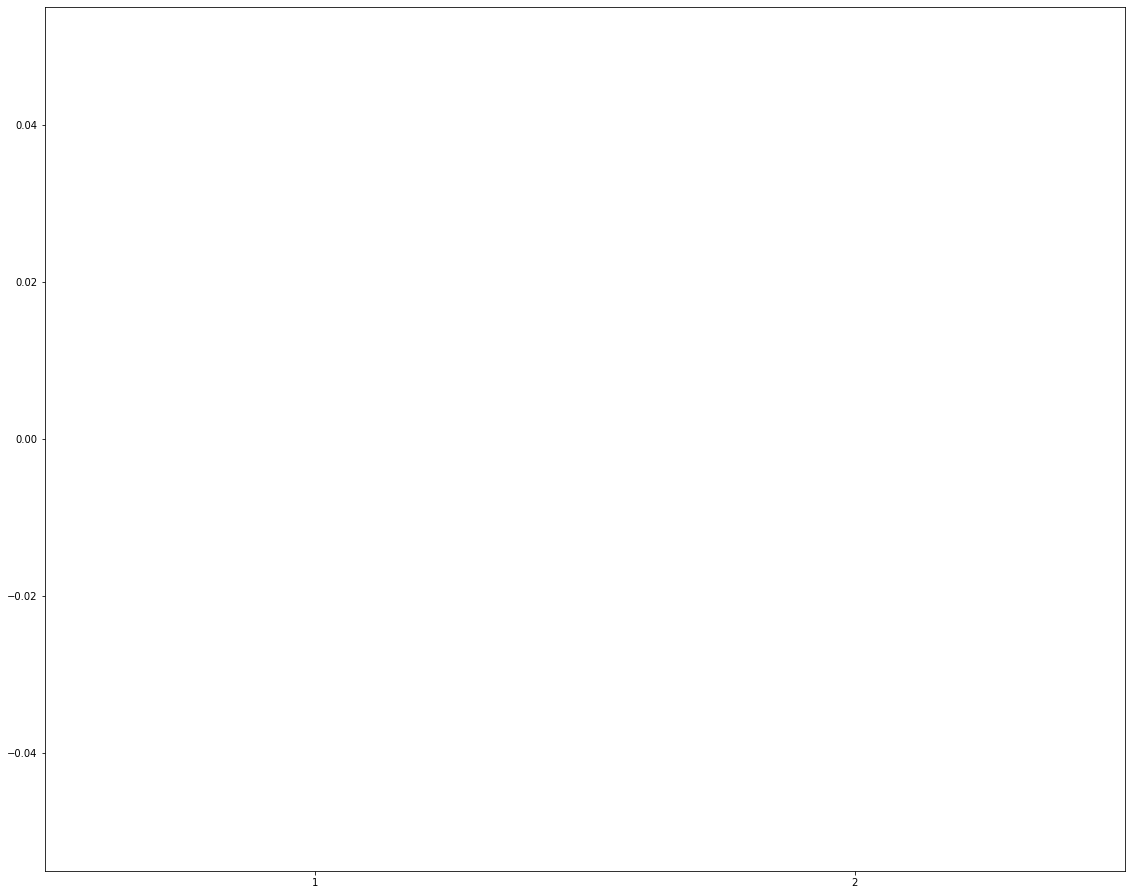

In [ ]:
import numpy as np

dataTH=[datos_WATER.READINGTHOUSANDTH, datos_WATER.DELTATHOUSANDTH]

fig = plt.figure(figsize=(15,12))

ax=fig.add_axes([0,0,1,1])

bp=ax.boxplot(dataTH)

plt.show()

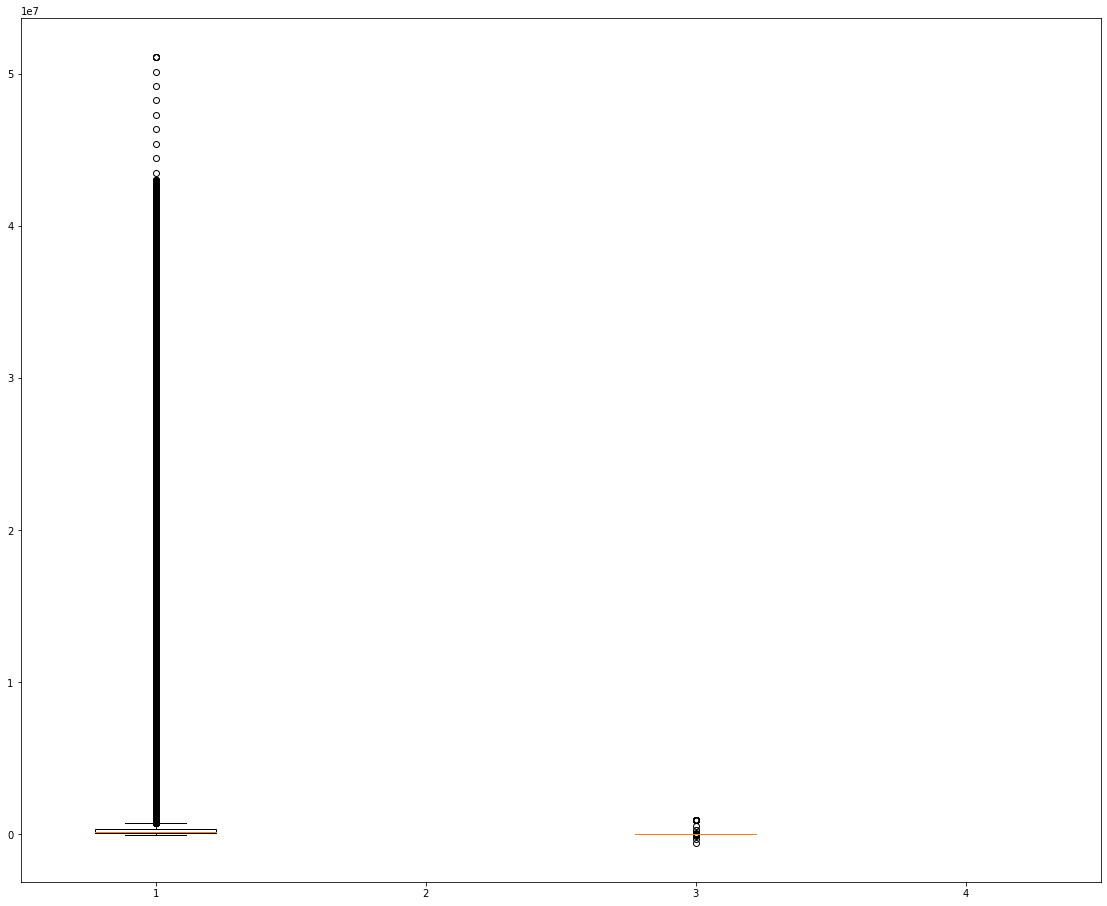

In [ ]:
import numpy as np

dataINTEGER=[datos_WATER.READINGINTEGER, datos_WATER.DELTAINTEGER]

fig = plt.figure(figsize=(15,12))

ax=fig.add_axes([0,0,1,1])

bp=ax.boxplot(dataINTEGER)

plt.show()


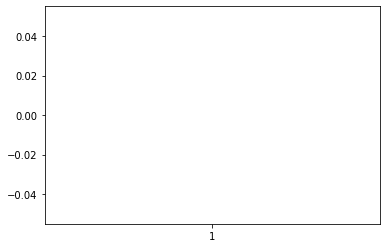

In [ ]:
plt.boxplot(datos_WATER.READINGTHOUSANDTH)
plt.show()

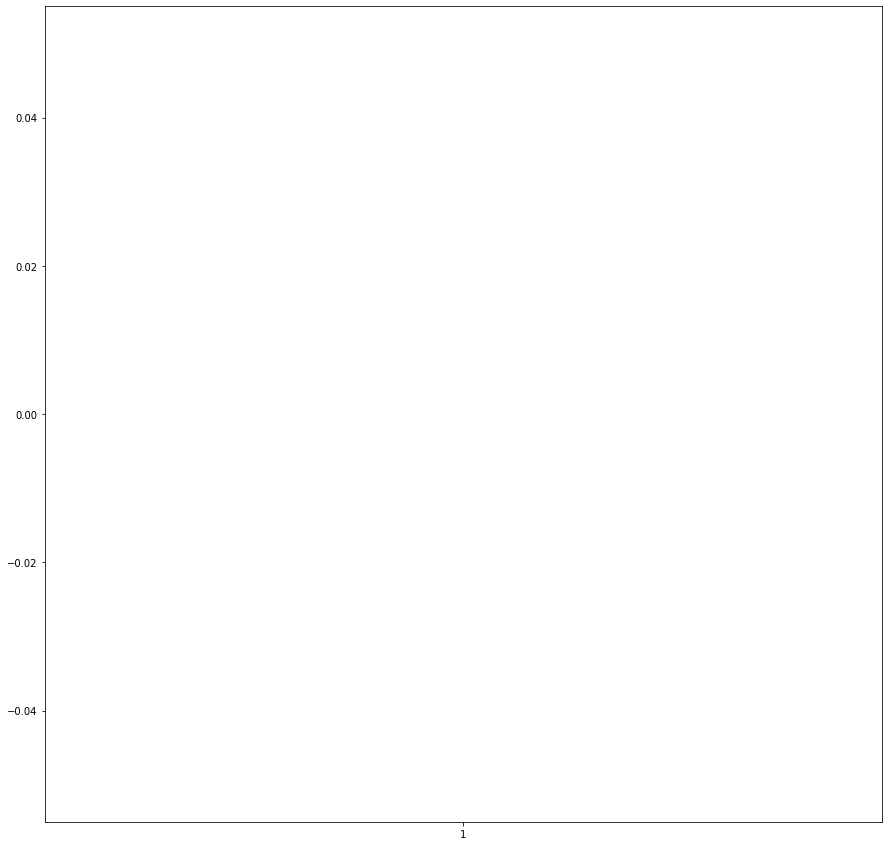

In [ ]:
import matplotlib.pyplot as plt

fig1=plt.figure(figsize=(15,15))

plt.boxplot(datos_WATER.READINGTHOUSANDTH)
plt.show()

In [ ]:
datos_WATER.head(10)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,READING
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0,369320.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0,369403.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0,369403.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0,369284.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0,369356.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0,369283.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0,369401.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0,369323.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0,369511.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0,369552.0


In [ ]:
ID=datos_WATER.ID.unique()

In [ ]:
print(ID)

[   0    1    2 ... 2748 2749 2756]


In [ ]:
datos_ID0=datos_WATER[datos_WATER.ID==0]
datos_ID0.head(30)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0


In [ ]:
datos_ID0.head(30)

,ID,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,READING
0,0,2019-06-13 08:34:09,369320,0.0,17,0.0,369320.0
1,0,2019-06-13 17:34:10,369403,0.0,2,0.0,369403.0
2,0,2019-06-13 18:34:10,369403,0.0,0,0.0,369403.0
3,0,2019-06-13 04:34:10,369284,0.0,1,0.0,369284.0
4,0,2019-06-13 14:34:10,369356,0.0,28,0.0,369356.0
5,0,2019-06-13 01:34:09,369283,0.0,0,0.0,369283.0
6,0,2019-06-13 16:34:10,369401,0.0,42,0.0,369401.0
7,0,2019-06-13 10:34:09,369323,0.0,0,0.0,369323.0
8,0,2019-06-13 22:34:08,369511,0.0,15,0.0,369511.0
9,0,2019-06-13 23:34:08,369552,0.0,41,0.0,369552.0


In [ ]:
varias lecturas por dia
contador que funciona mal...¿?
web librería prophet

In [ ]:
datos_ID1=datos_WATER[datos_WATER.ID==1]
print(datos_ID1)

       ID           SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
8759    1  2019-06-13 02:34:26  ...             0              0.0
8760    1  2019-06-13 17:34:26  ...             0              0.0
8761    1  2019-06-13 23:00:00  ...             1              2.0
8762    1  2019-06-13 00:34:26  ...             0              0.0
8763    1  2019-06-13 06:34:25  ...             0              0.0
...    ..                  ...  ...           ...              ...
17513   1  2020-01-14 11:00:00  ...             0              0.0
17514   1  2020-01-14 21:00:00  ...             0              0.0
17515   1  2020-01-24 16:00:00  ...             0             33.0
17516   1  2020-01-25 09:24:29  ...             0              0.0
17517   1  2020-01-25 16:00:00  ...             0              0.0

[8759 rows x 6 columns]


In [ ]:
datos_ID2=datos_WATER[datos_WATER.ID==2]
print(datos_ID2)

       ID           SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
17518   2  2019-06-13 07:18:38  ...             0              0.0
17519   2  2019-06-13 17:18:37  ...             0              0.0
17520   2  2019-06-13 19:18:37  ...             0              0.0
17521   2  2019-06-13 16:18:37  ...             0              0.0
17522   2  2019-06-13 09:18:38  ...             0              0.0
...    ..                  ...  ...           ...              ...
26272   2  2020-01-11 21:06:10  ...             0              0.0
26273   2  2020-01-24 16:05:28  ...            11              0.0
26274   2  2020-01-25 16:05:24  ...             0              0.0
26275   2  2020-01-25 11:05:24  ...             0              0.0
26276   2  2020-01-26 06:05:20  ...             0              0.0

[8759 rows x 6 columns]


In [ ]:
datos_ID2748=datos_WATER[datos_WATER.ID==27]
print(datos_ID2748)

        ID           SAMPLETIME  ...  DELTAINTEGER  DELTATHOUSANDTH
231251  27  2019-06-13 16:43:15  ...            13              0.0
231252  27  2019-06-13 02:43:17  ...             0              0.0
231253  27  2019-06-13 13:43:15  ...            13              0.0
231254  27  2019-06-13 23:43:12  ...             8              0.0
231255  27  2019-06-13 01:43:17  ...             2              0.0
...     ..                  ...  ...           ...              ...
240005  27  2019-04-23 06:45:03  ...             0              0.0
240006  27  2019-04-23 04:45:03  ...             0              0.0
240007  27  2020-01-11 04:36:00  ...             0              0.0
240008  27  2020-01-13 23:35:58  ...             2              0.0
240009  27  2020-01-14 04:35:57  ...             0              0.0

[8759 rows x 6 columns]
